In [1]:
from utils import plotting, transform, ingest
from forecast import stats

In [2]:
import seaborn as sns

sns.set(rc={"figure.figsize": (11, 8.3)})

In [3]:
cols = ["HOUST", "PERMIT"]
regions = ["NE", "MW", "S", "W"]

regional_hst = [f"HOUST{r}" for r in regions]

In [4]:
raw_df = ingest.import_fred()

parsed_df = transform.standard(raw_df)

houst_reg = parsed_df[regional_hst]

Using cached data at data/fred_data.csv


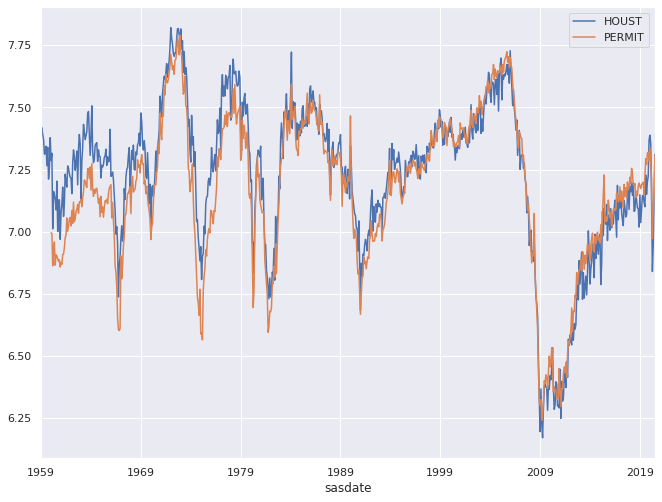

In [5]:
fig = plotting.plot_subdf(parsed_df, cols, figname="national", mul_axis=False)

fig.show()

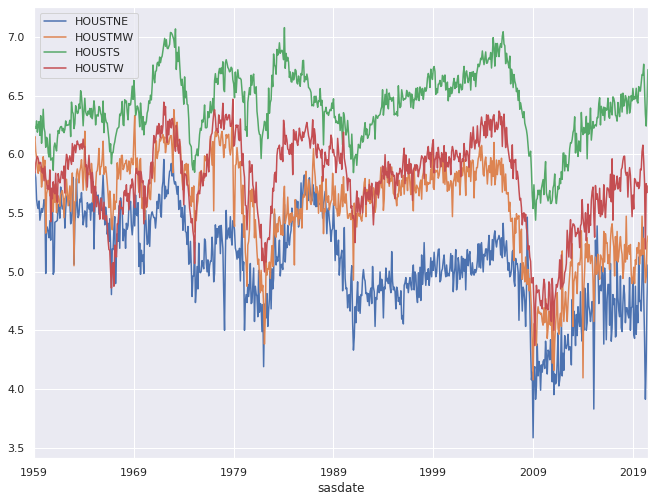

In [6]:
fig = plotting.plot_subdf(parsed_df, regional_hst, figname="regional-houst", mul_axis=False)
fig.show()

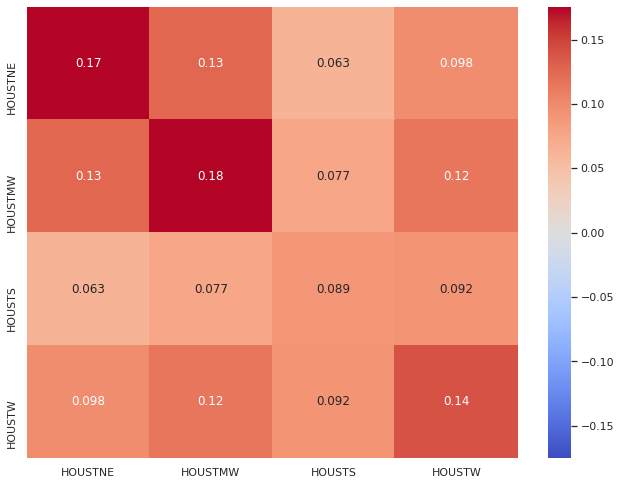

In [7]:
cov, var_names = stats.sample_covariance(houst_reg)
fig = plotting.plot_covariance(cov, var_names, save_data=True, name="regional-cov", annot=True)

fig.show()

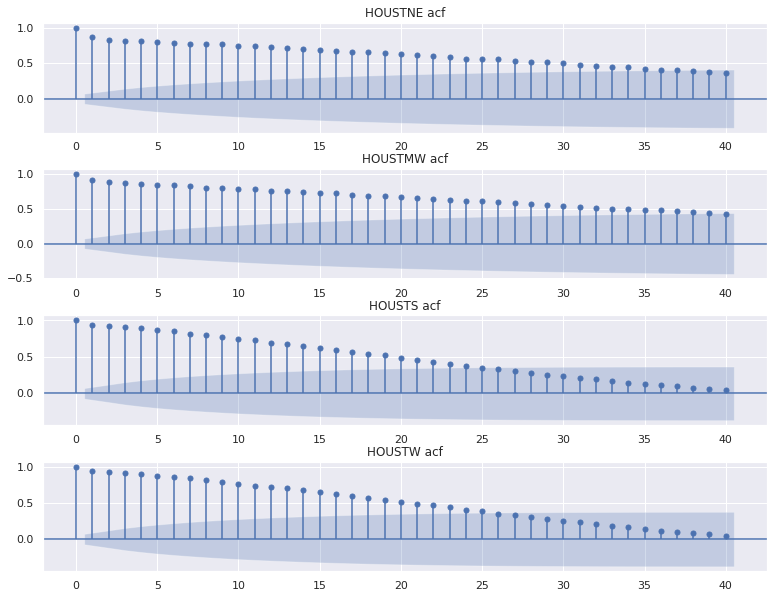

In [8]:
fig = plotting.plot_acf(houst_reg, figname="regional-acf")
fig.show()

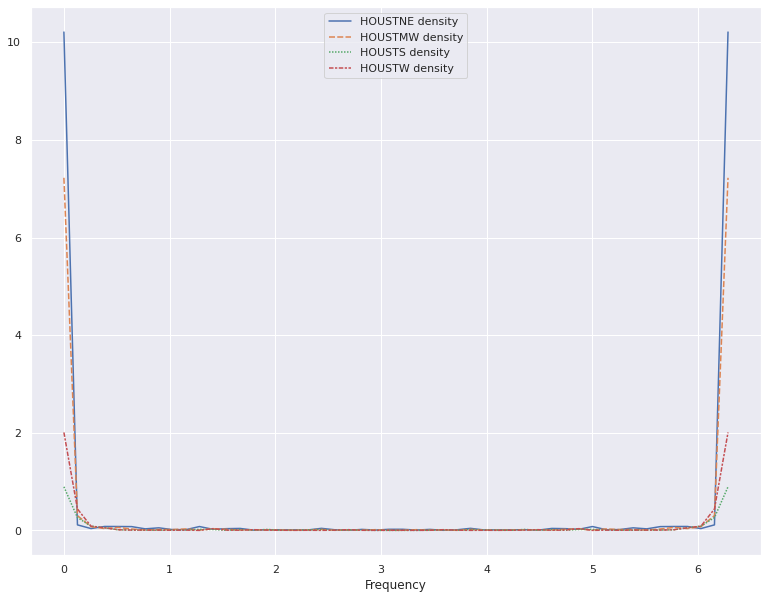

In [14]:
fig = plotting.plot_density(houst_reg, lambda X: stats.spectral_density(X, 800))

fig.show()